<a href="https://colab.research.google.com/github/Mineth03/Client-Predicting/blob/Model_Neural_Network/Models/NeuralNetworkModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1716/1716 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7767 - loss: 0.4809 - val_accuracy: 0.8659 - val_loss: 0.3183
Epoch 2/20
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8597 - loss: 0.3445 - val_accuracy: 0.8646 - val_loss: 0.3128
Epoch 3/20
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8615 - loss: 0.3347 - val_accuracy: 0.8685 - val_loss: 0.3089
Epoch 4/20
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8649 - loss: 0.3308 - val_accuracy: 0.8721 - val_loss: 0.3053
Epoch 5/20
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8678 - loss: 0.3235 - val_accuracy: 0.8705 - val_loss: 0.3043
Epoch 6/20
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8677 - loss: 0.3214 - val_accuracy: 0.8730 - val_loss: 0.3037
Epoch 7/20
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8676 - loss: 0.3218 - val_accuracy: 0.8728 - val_loss: 0.3002
Epoch 8/20
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8672 - loss: 0.3196 - val_ac

<Figure size 800x600 with 0 Axes>

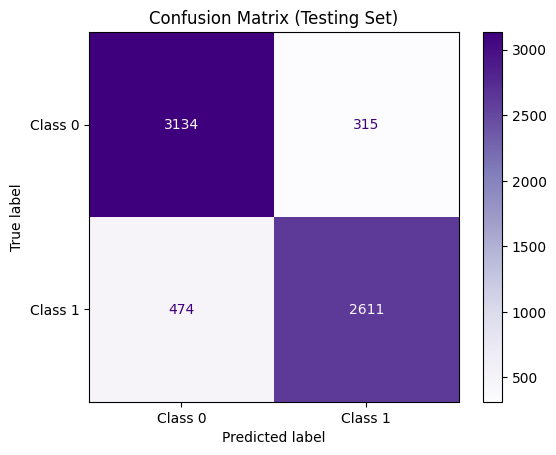

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("Scaled.csv")

# Separate features (X) and target (y)
X = data.drop('y', axis=1)
Y = data['y']

# Split the data into training (80%) and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

# Further split the 20% into validation (10%) and testing (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = Sequential([
    Dense(128, input_shape=(X_train_smote.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val, y_val),
    epochs=20,  # Adjust based on performance
    batch_size=32,  # Mini-batch size
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get predictions for the training set
y_train_pred = (model.predict(X_train_smote) > 0.5).astype(int)  # Threshold at 0.5
y_train_smote_actual = y_train_smote.values  # Convert to numpy array if necessary

# Get predictions for the testing set
y_test_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold at 0.5

# Classification report for training set
print("Classification Report (Training Set):")
print(classification_report(y_train_smote_actual, y_train_pred))
# Classification report for testing set
print("Classification Report (Testing Set):")
print(classification_report(y_test, y_test_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score (Testing Set): {roc_auc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix (Testing Set)")
plt.show()